## 2. Encoding

We want to understand how neurons encode information about the external world. Many methods focus on describing how neural firing relates to stimuli using tuning curves or receptive fields. In this tutorial we will make use of the population response to fit a particular class of models (GLMs) which describes how neurons interact and influence one another. We will fit typical versions of GLMs to data containing _in vitro_ responses of 4 retinal ganglion cells (RGCs) stimulated with 120 Hz spatio-temporal binary white noise.  There are 2 ON RGCs and 2 OFF RGCs in this dataset. The experiment was performed by [Uzzell & Chichilnisky 2004](https://www.physiology.org/doi/full/10.1152/jn.01171.2003) and GLMs were famously applied to this dataset by [Pillow et. al 2008](https://www.nature.com/articles/nature07140). So This tutorial is based on exercises made by  Jonathan Pillow (Homework 3 of http://pillowlab.princeton.edu/teaching/statneuro2018/). 

The data contains 3 variables: 

- `Stim`, a vector of length 144051 with the stimulus intensities 0.48 or -0.48.
- `SpCounts` a matrix of size 144051 times 4 matrix of spike counts. Each column contains the spike counts of one neuron.
- `dtStim`, the size of a single time bin (in seconds). You can use this to convert the spike counts predicted by your model (units spikes /bin) into units of spikes / s. The stimulus frame rate is given by 1/dtStim.

We will perform the most important steps in fitting GLMs:
* Building the design matrix
* Fitting the stimulus filters



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat, savemat

## 1. Load the data 


In [2]:
data = loadmat('RGCdata.mat')
stim = data['Stim']
spike_counts = data['SpCounts']
dt = data['dtStim']

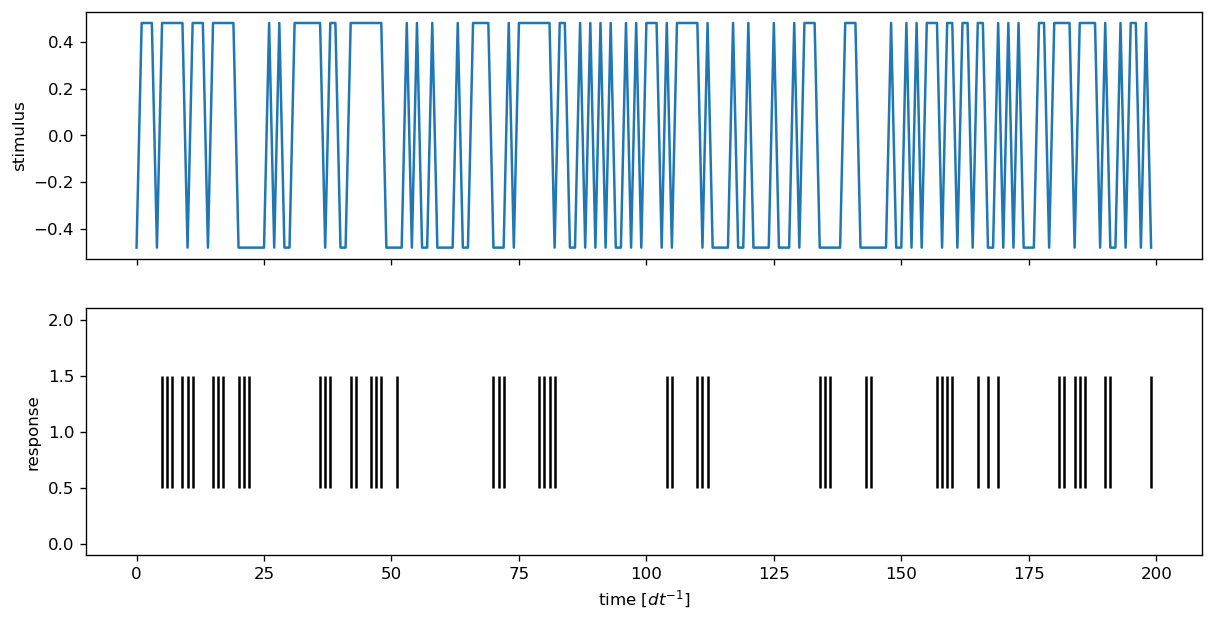

In [3]:
num = 200
spikes_trans = []
for i in range(num):
    if spike_counts[i,3] != 0:
        spikes_trans = np.append(spikes_trans, i)

fig, axs = plt.subplots(2,1, sharex=True, figsize=(12,6), dpi=120)
axs[0].plot(stim[:num])
axs[0].set_ylabel('stimulus')
axs[1].eventplot(spikes_trans, color='k')
axs[1].set_ylabel('response')
axs[1].set_xlabel(r'time [$dt^{-1}$]')
plt.show()

## 2. Building the design matrix

The first step in fitting a GLM is building the so-called design matrix. This is a $T \times d$ matrix, where $T$ is the total number of time bins and $d$ is the length of the stimulus filter. Each row contains $d$ time bins of the stimulus that will be used to predict the response of a neuron at the end of those $d$ time bins. 

**1.** Create the design matrix $X$ by filling in the design matrix. Note that we assume values of `Stim`=0 for the 24 time bins prior to the first time bin of the response. (This is known as "zero-padding", so that the design matrix has the same number of rows as the response vectors in `spike_counts`.) Make an image plot showing the first 50 rows of the design matrix (i.e., a $50 \times 25$ matrix).

(144051, 25)


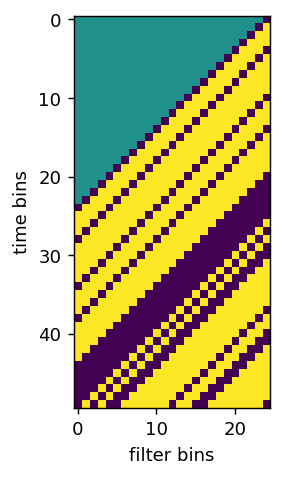

In [4]:
T = spike_counts.shape[0]
d = 25
# Assume stim=0 for prior bins
padded_stim = np.concatenate((np.zeros((d-1,1 )), stim))
X = np.zeros((T, d))

for t in range(T):
    # Your code goes here:
    X[t] = padded_stim[t:t+d].T
print(np.shape(X))

plt.figure(dpi=130)
plt.imshow(X[:50], cmap='viridis')
plt.ylabel('time bins')
plt.xlabel('filter bins')
plt.show()

**2)** For the first neuron, compute the spike-triggered average,  $STA = Y^T X \,/\, \textrm{sum}(Y)$, where $Y$ is the vector of spike counts of the neuron (i.e., the first column of `spike_counts`). Compare with the STA's of the other neurons. Which cells are ON RGCs and which are OFF RGCs?

(4, 25)


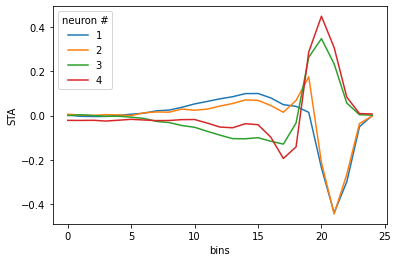

In [5]:
def STA(Y, X):
    return (np.transpose(Y) @ X) / np.sum(Y)

spike_num = spike_counts.shape[1]
STA_all = np.zeros((spike_num,d))
for i in range(spike_num):
    STA_all[i] = STA(Y=spike_counts[:,i], X=X)
print(STA_all.shape)

[plt.plot(STA_all[i], label=i+1) for i in range(spike_num)]
plt.ylabel('STA')
plt.xlabel('bins')
plt.legend(title='neuron #')
plt.show()

--> Neurons 3 & 4 look to be ON RGCs, while neurons 1 & 2 are OFF RGCs.

## Fitting a linear-Gaussian GLM


**3.** The family of GLMs comprises of different types, determined by the type of noise and the output non-linearity they use. The linear-Gaussian GLM is the simplest type of GLM. It models neural responses as a linear function of the stimulus, corrupted by Gaussian noise:
$$
y = X\beta + \epsilon,
$$
Here $\beta$ is the stimulus filter of size $d \times 1$ and $\epsilon$ is a standard Gaussian random variable. In other words, the probability  of a spike count $y$ given a stimulus $x$ is $P(y|X\beta)$, where $P$ denotes the Gaussian probability density with mean $X\beta$.

The optimal filter of the linear Gaussian GLM (the maximum likelihood estimate of $\beta$) is given by
$$
\hat{\beta} = (X^T X)^{-1} (X^T Y).
$$
Note that this is equal to the STA, but multiplication by the inverse of the stimulus covariance matrix $X^T X$. Without this scaling, our stimulus filter would be biased by temporal correlations in the stimulus.

The code below adds a column of 1's to the design matrix. This means that the last element of our stimulus filter will be an intercept that accounts for the mean of Y (the neuron's average firing rate). Complete the code below by using the above formula to compute the optimal filter. 

Plot the resulting filter together with the STA. 

(4, 26)


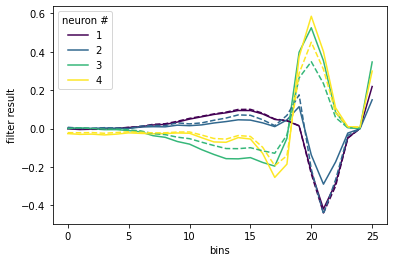

In [6]:
# Add a constant column to X for a coefficient
X_design = np.ones((T,d+1)) 
X_design[:,:-1] = X

# Your code goes here:
def beta_hat(Y, X):
    return np.linalg.inv(X.T @ X) @ (X.T @ Y)

beta_hat_all = np.zeros((spike_num,d+1))
for i in range(spike_num):
    beta_hat_all[i] = beta_hat(Y=spike_counts[:,i], X=X_design)
print(np.shape(beta_hat_all))

colors = plt.cm.viridis(np.linspace(0, 1, spike_num))
[plt.plot(beta_hat_all[i], label=i+1, c=colors[i]) for i in range(spike_num)]
[plt.plot(STA_all[i], c=colors[i], ls='--') for i in range(spike_num)]
plt.ylabel('filter result')
plt.xlabel('bins')
plt.legend(title='neuron #')
plt.show()

Question:
    The STA and the MLE filter look very similar. Why do you think this is? Tip: think about the properties of the stimulus. 

--> The stimulus is white noise. With the MLE only being different with a multiplication by the inverse of the stimulus covariance matrix, along with the stimulus being white noise, this leads to the similarity.

Plot the first 100 time bins of the spike counts together with the estimate $X\beta$ from the linear-Gaussian model. 

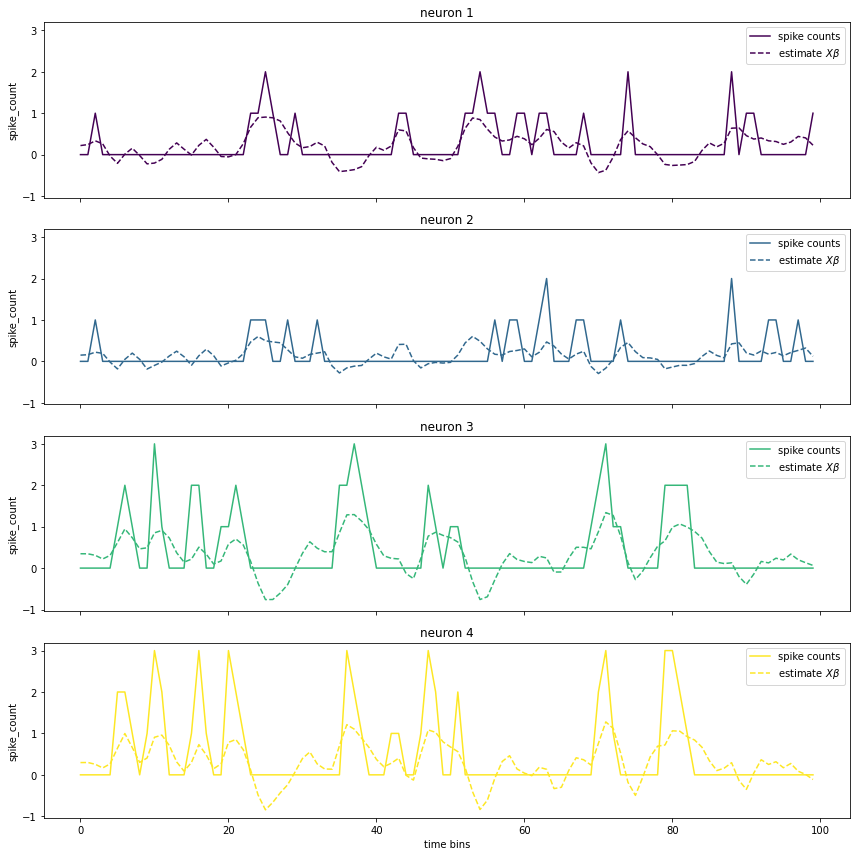

In [7]:
colors = plt.cm.viridis(np.linspace(0, 1, spike_num))
fig, axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(12,12))
for i in range(spike_num):
    axs[i].plot(spike_counts[:100,i], c=colors[i], label='spike counts')
    axs[i].plot((X_design @ beta_hat_all.T)[:100,i], c=colors[i], ls='--', label=r'estimate $X \beta$')
    axs[i].set_title('neuron {}'.format(i+1))
    axs[i].set_ylabel('spike_count')
    if i == spike_num-1:  axs[i].set_xlabel('time bins')
    axs[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

Question:
    The estimate spike count should be roughly similar the same trend as the true spike count, but it is an unrealistic estimate in at least one way. In which way is it unrealistic and how is this related to the properties of the linear-Gaussian model?

--> The estimate can have a negative spike count. Therefore, unrealistic due to no bounds on the sign from the linear model.

## Fitting a Poisson GLM

**5.** The linear-Gaussian GLM is convenient because we have a formula for the optimal filter but as we saw, it lacks realism. A popular model for spike counts is the Poisson GLM, according to which the probability of a spike count $y$ given stimulus $X$ is again $P(y|X\beta)$, but now $P$ is a Poisson distribution with rate $\lambda = X\beta$. 
It is given by 
$$
P(y|\lambda) = \frac{e^{-\lambda} \lambda^y}{y!}, \;\; \lambda=X\beta.
$$
There is no formula for the $\hat{\beta}$ that maximizes the $P(y|X\beta)$. Instead, we can use a numerical optimization routine from `scipy` to find it. In practice, we find the $\hat{\beta}$ that minimizes the negative log likelihood $-\log P(Y|X\beta)$, which is equivalent but mathematically more convenient to maximizing $P(Y|X\beta)$.

In [8]:
def neg_ll(w, Y, X):
    """ w : (d, ) stimulus filter
        Y : (n, ) spike counts
        X : (n, d) design matrix 
    """
    filter_out = X.dot(w)
    y_hat = np.exp(filter_out)
    ll = Y.dot(filter_out) - y_hat.sum()
    ll /= len(Y)
    return -ll

**6.** Use the function `minimize` to find the maximum-likelihood estimate of the weight vector $w$ under the Poisson GLM, using the function `neg_ll`. 

Tip:  `minimize` takes as as arguments: the function you want to minimize, an initial guess for the parameters you minimize over and the data `(X_design,Y)` that are needed by `neg_ll`. To assess the model fit, you can look at the log likelihood of the fitted filter. 

In [9]:
# Your code for minimizing neg_ll:
initial_weight = 0.1
w = np.full(d, initial_weight)
poisson_all = np.zeros((spike_num,d))
for i in range(spike_num):
    res = minimize(neg_ll, w, (spike_counts[:,i], X), options={'disp': False})
    poisson_all[i] = res.x
print(np.shape(poisson_all))

(4, 25)


Plot the filter estimate on the same axes as the STA and linear-Gaussian model estimate. Normalize all the vectors
so they are on the same scale.

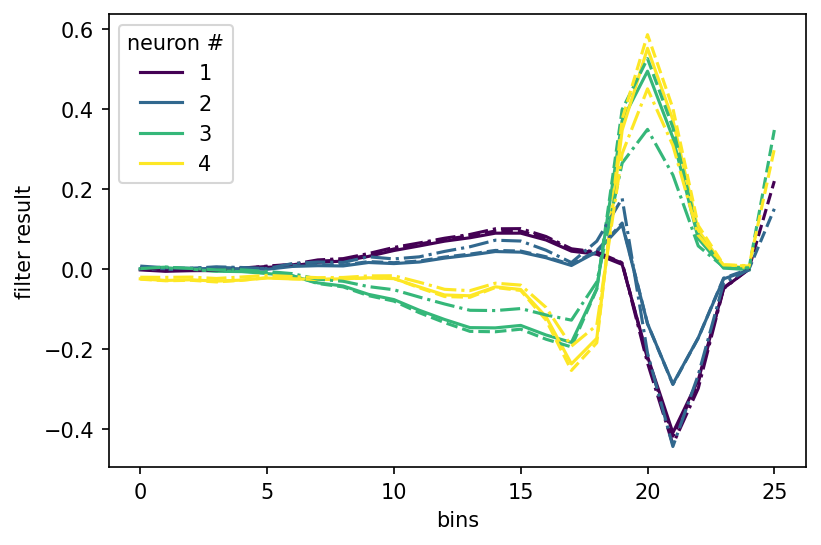

In [10]:
# Your code for plotting the filter goes here:
colors = plt.cm.viridis(np.linspace(0, 1, spike_num))
plt.figure(dpi=150)
[plt.plot(poisson_all[i], label=i+1, c=colors[i]) for i in range(spike_num)]
[plt.plot(beta_hat_all[i], c=colors[i], ls='--') for i in range(spike_num)]
[plt.plot(STA_all[i], c=colors[i], ls='-.') for i in range(spike_num)]
plt.ylabel('filter result')
plt.xlabel('bins')
plt.legend(title='neuron #')
plt.show()

Plot the first 100 bins of the estimated firing rates. Does these estimates look more realistic than the linear-Gaussian estimates?

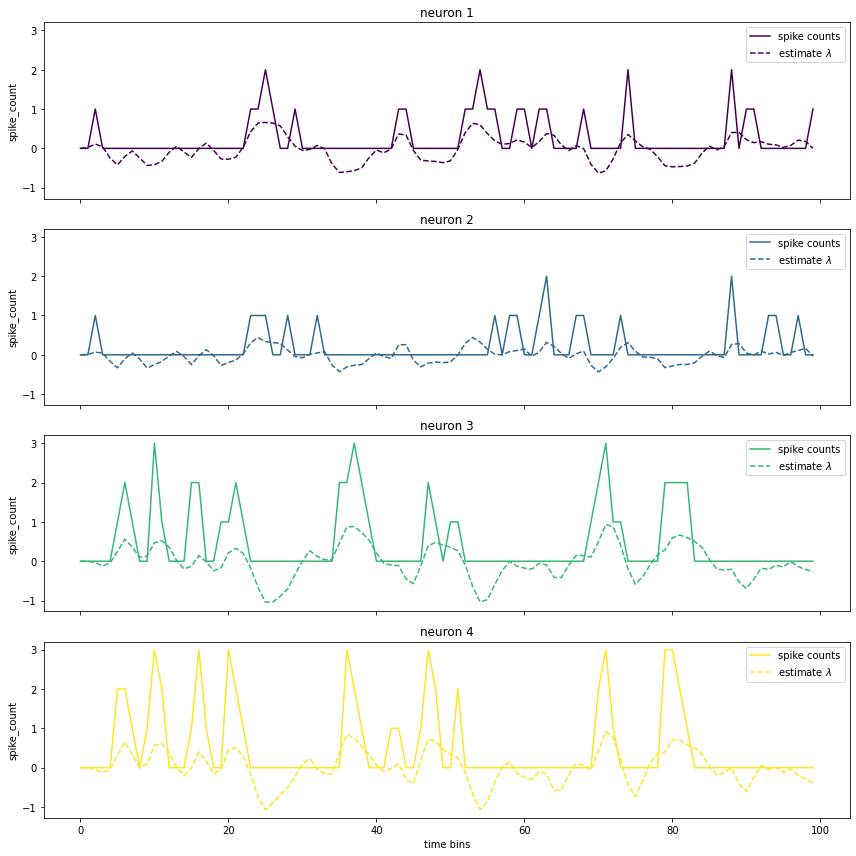

In [11]:
# Your code for plotting the estimate goes here:
colors = plt.cm.viridis(np.linspace(0, 1, spike_num))
fig, axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(12,12))
for i in range(spike_num):
    axs[i].plot(spike_counts[:100,i], c=colors[i], label='spike counts')
    axs[i].plot((X @ poisson_all.T)[:100,i], c=colors[i], ls='--', label=r'estimate $\lambda$')
    axs[i].set_title('neuron {}'.format(i+1))
    axs[i].set_ylabel('spike_count')
    if i == spike_num-1:  axs[i].set_xlabel('time bins')
    axs[i].legend(loc='upper right')
plt.tight_layout()
plt.show()


## Adding spike-history to the GLM

The likelihood of a neuron's firing is not just dependent on the stimulus, but also on its own history. To fit neurons that burst or adapt, we need to include a spike-history filter.

**6.** Augment the design matrix $X$ to include 20 bins of spike-history from neuron 1 (i.e. grab the previous 20 time bins of $Y$ for time bin, and insert them into the design matrix). 

In [12]:
Y = spike_counts[:,0]

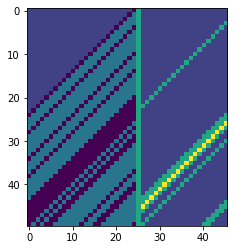

In [13]:
d_hist = 20
X_hist = np.zeros((T, d_hist))
padded_hist = np.concatenate((np.zeros((d_hist-1, )), Y))

Y[:d_hist].shape
for t in range(T):
    # Your code goes here: 
    start_idx = t - d_hist
    if t == 0:
        pass
    elif start_idx < 0:
        X_hist[t][-t:] = Y[:t]
    else:
        X_hist[t] = Y[start_idx:t]
    
# append the two matrices and show them
X_new = np.concatenate((X_design, X_hist), axis=1)
plt.imshow(X_new[:50])
plt.show()

Fit the Poisson-GLM using this larger design matrix. Plot the stimulus filter, and the spike-history filter.  How much higher is the log-likelihood of this new model?  

In [14]:
w0 = Y.dot(X_new)/len(Y) # 'STA'
# Your code goes here: minimize neg_ll_exp with w0 as initial guess
history_all = np.zeros((spike_num,d_hist+d+1))
for i in range(spike_num):
    res_hist = minimize(neg_ll, w0, (spike_counts[:,i], X_new), options={'disp': False})
    history_all[i] = res_hist.x
print(np.shape(history_all))

(4, 46)


In [15]:
# Compre negative log likelihoods
print("Neg ll: %0.2f:"%res['fun'])
print("Neg ll: %0.2f:"%res_hist['fun'])

Neg ll: 0.91:
Neg ll: 0.31:


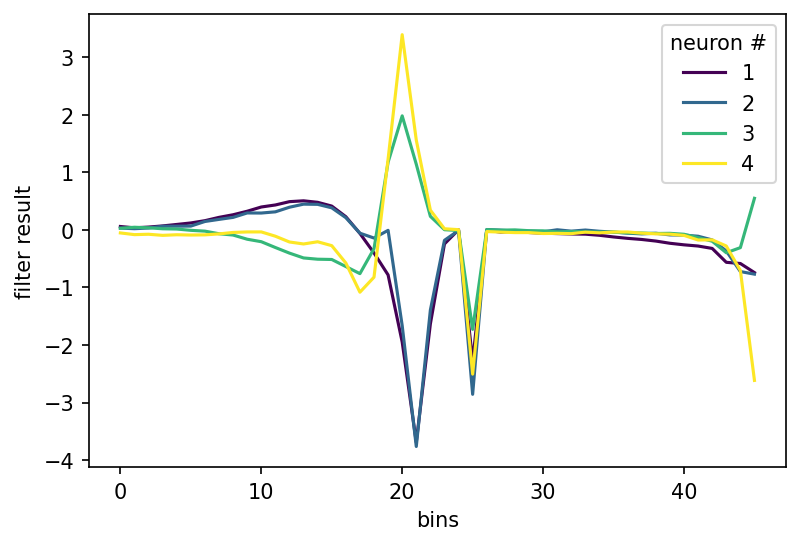

In [16]:
# Plot the filters:
colors = plt.cm.viridis(np.linspace(0, 1, spike_num))
plt.figure(dpi=150)
[plt.plot(history_all[i], label=i+1, c=colors[i]) for i in range(spike_num)]
# [plt.plot(poisson_all[i], label=i+1, c=colors[i]) for i in range(spike_num)]
# [plt.plot(beta_hat_all[i], c=colors[i], ls='--') for i in range(spike_num)]
# [plt.plot(STA_all[i], c=colors[i], ls='-.') for i in range(spike_num)]
plt.ylabel('filter result')
plt.xlabel('bins')
plt.legend(title='neuron #')
plt.show()

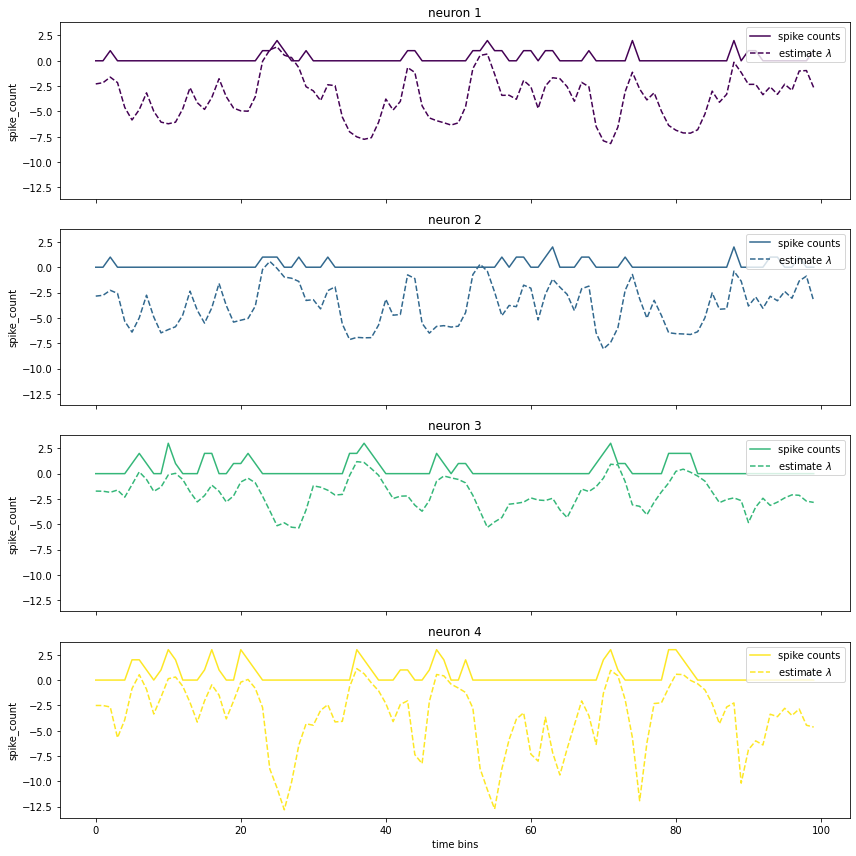

In [17]:
# Your code for plotting the estimate goes here:
colors = plt.cm.viridis(np.linspace(0, 1, spike_num))
fig, axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(12,12))
for i in range(spike_num):
    axs[i].plot(spike_counts[:100,i], c=colors[i], label='spike counts')
    axs[i].plot((X_new @ history_all.T)[:100,i], c=colors[i], ls='--', label=r'estimate $\lambda$')
    axs[i].set_title('neuron {}'.format(i+1))
    axs[i].set_ylabel('spike_count')
    if i == spike_num-1:  axs[i].set_xlabel('time bins')
    axs[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

## Further exercises

* By including the a spike-history filter, we increase the number of parameters of the model. This can lead to overfitting (noisy filter estimates), especially when we have little data. Use ridge regression to combat overfitting.
* Neural activity is correlated, which means we can improve our encoding model by using the spike history of other neurons. This is done by including these in the design matrix, analogous to the way we included the spike history of the neuron itself. See if fitting such 'spike-coupling' filters indeed improves our prediction.